# Opening a SNiPER EDM

In [1]:
import orsa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

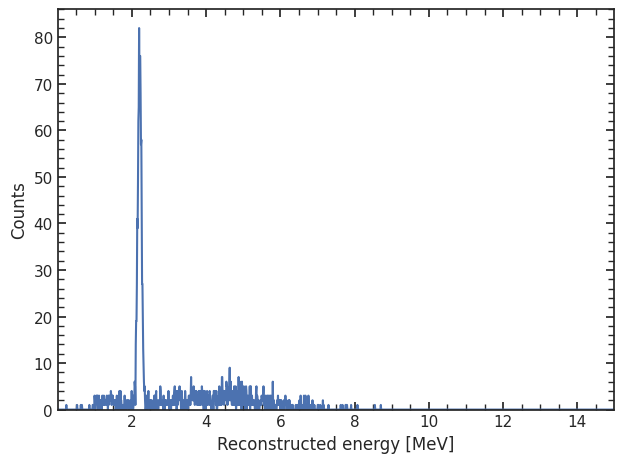

In [2]:
reco = orsa.sniper.load_edm('inputs/reactor_edm.root').to_list()

bins = np.arange(0, 15, 0.01)
reco.to_hist(bins)

In [3]:
promptlist, delayedlist = orsa.selection.standard(reco)

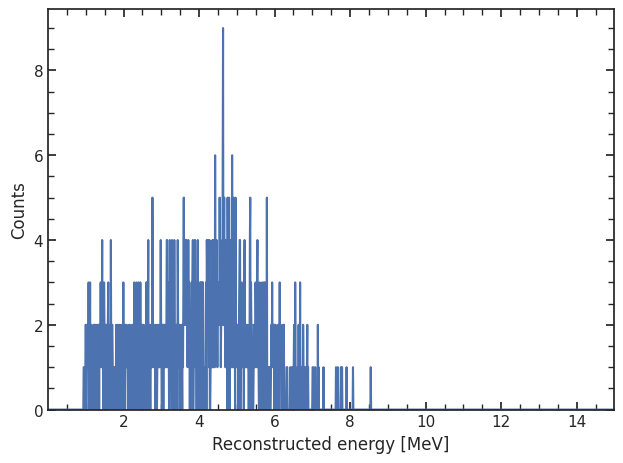

In [4]:
promptlist.to_hist(bins)

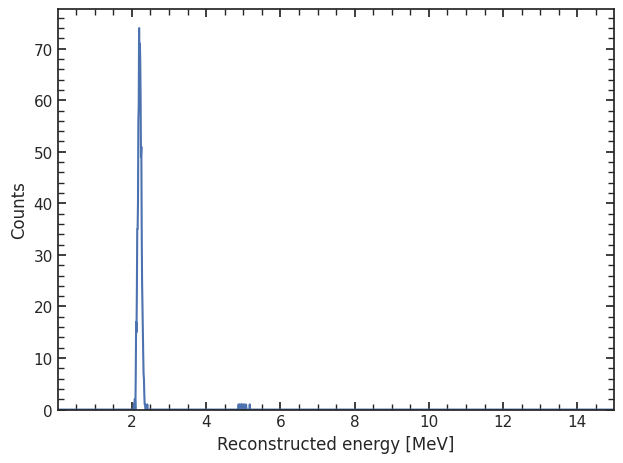

In [5]:
delayedlist.to_hist(bins)

## Let's try a fit

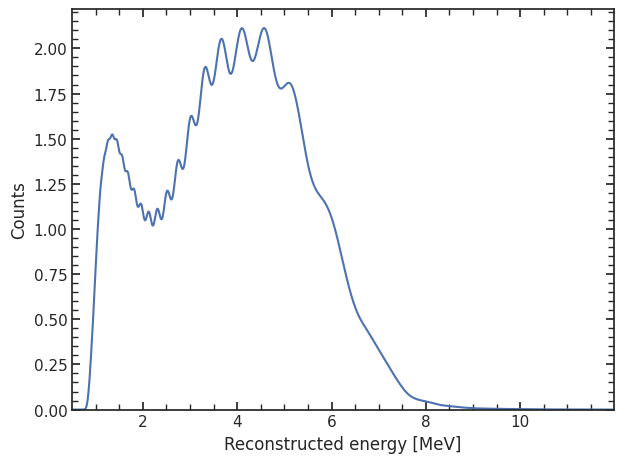

In [6]:
model = orsa.model.Model([], np.arange(0.5, 12, 0.01), 0.8, 11, orsa.oscillation.default(), orsa.detector.default(), False, False, False, rebin = 1, exposure = 1)

model.add_parameter(orsa.model.DetectorParameter(label = 'eff', value = 1,          error = 0.01,   prior = {'positive': None},   formatted_label = r'$\epsilon$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a',   value = 0.02614,    error = 0.0077, prior = {'positive': None},   formatted_label = r'$a$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'b',   value = 0.006401,   error = 0.012,  prior = {'positive': None},   formatted_label = r'$b$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'c',   value = 0.01205,    error = 0.033,  prior = {'positive': None},   formatted_label = r'$c$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a0',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_0$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a1',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_1$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a2',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_2$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a3',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_3$'))

model.add_parameter(orsa.model.OscillationParameter(label = 'rho',      value = 2.45,       error = 0.06,   prior = {'positive': None}, formatted_label = r'$\rho$'))
model.add_parameter(orsa.model.OscillationParameter(label = 'dm2_21',   value = 7.53e-5,    error = np.inf,                       formatted_label = r'$\Delta m^2_{21}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 'dm2_31',   value = 2.5283e-3,  error = np.inf,                       formatted_label = r'$\Delta m^2_{31}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 's2_12',    value = 0.307,      error = np.inf,                       formatted_label = r'$\sin^2 \theta_{12}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 's2_13',    value = 0.0218,     error = np.inf,                       formatted_label = r'$\sin^2 \theta_{13}$'))

# norm_scale = 6*365.25 # 6 years
shape_fact = np.sqrt(36e-03/model.bin)
shape_fact_20 = np.sqrt(20e-03/model.bin)

gen_dict = dict()
gen_dict['rea'] = orsa.generator.sniper('reactors', True, shape_uncertainty='tao')

model.add_parameter(orsa.model.NormalizationParameter(label = 'rea',   value = promptlist.n,    generator = gen_dict['rea'],     error = 0.02,     is_oscillated=True, has_duty=False,      formatted_label = r'$N_\mathrm{rea}$'))

asimov = model.get_spectrum(asimov = True).to_hist()
asimov

In [7]:
init_model = model.copy()
data_hist = promptlist.to_hist(asimov.Eedges)
min_func_bin = orsa.probability.CostFunction(ll=orsa.probability.chi2, ll_args=dict(data=data_hist))
model.use_shape_uncertainty = False
res = orsa.fit.minuit(model, min_func_bin)

Cost function parsed as chi2-like


In [8]:
res.obj

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 374.1                      │              Nfcn = 384              │
│ EDM = 3.99e-05 (Goal: 0.0002)    │            time = 6.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ eff    │   1.001   │   0.010   │            │            │         │         │       │
│ 1 │ a      │ 26.14e-3  │  0.20e-3  │            │            │         │         │       │
│ 2 │ b      │  6.40e-3  │  0.08e-3  │            │            │         │         │       │
│ 3 │ c      │  12.0e-3  │  0.4e-3   │            │            │         │         │       │
│ 4 │ a0     │    -0     │     1     │            │            │         │         │       │
│ 5 │ a1     │     0     │     1     │            │            │         │         │       │
│ 6 │ a2     │   -0.1    │    0.9    │            │            │         │         │       │
│ 7 │ a3     │     0     │     1     │            │            │         │         │       │
│ 8 │ rho    │   2.45    │   0.15    │            │            │         │         │       │
│ 9 │ dm2_21 │  73.4e-6  │  1.4e-6   │            │            │         │         │       │
│ 10│ dm2_31 │ 2.507e-3  │ 0.019e-3  │            │            │         │         │       │
│ 11│ s2_12  │   0.313   │   0.012   │            │            │         │         │       │
│ 12│ s2_13  │   0.041   │   0.021   │            │            │         │         │       │
│ 13│ rea    │  2.73e3   │  0.05e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │          eff            a            b            c           a0           a1           a2           a3          rho       dm2_21       dm2_31        s2_12        s2_13          rea │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    eff │     9.87e-05            0         0e-9            0      0.02e-3           -0           -0     -0.02e-3            0    375.1e-12      0.54e-9      0.01e-3      0.01e-3    -13.00e-3 │
│      a │            0     4.05e-08        -0e-9           -0     -0.04e-6     -0.08e-6      0.12e-6      0.07e-6           -0     -0.1e-12      0.01e-9           -0      0.01e-6      6.12e-6 │
│      b │         0e-9        -0e-9      5.9e-09        -0e-9        -3e-9        -3e-9         6e-9         4e-9        -0e-9           -0            0        -1e-9         2e-9       843e-9 │
│      c │            0           -0        -0e-9     1.58e-07     -0.04e-6     -0.11e-6      0.15e-6      0.09e-6           -0           -0      0.01e-9           -0      0.01e-6      3.18e-6 │
│     a0 │      0.02e-3     -0.04e-6        -3e-9

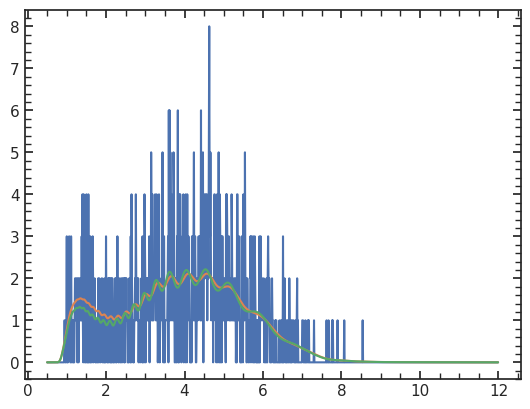

In [9]:
sp0 = init_model.get_spectrum(asimov=True)
sp1 = model.get_spectrum(asimov=True)

plt.plot(data_hist.E, data_hist.counts)
plt.plot(sp0.E, sp0.counts)
plt.plot(sp1.E, sp1.counts)

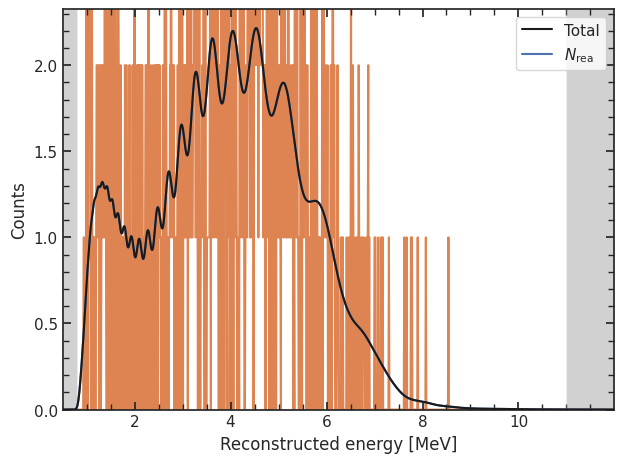

In [10]:
fig, ax = model.get_fig()
ax.plot(data_hist.E, data_hist.counts, zorder = -10)

/home/ubuntu/.miniconda3/lib/python3.10/site-packages/orsa/fit/minimizers.py:135: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(self.values, self.covariance, size=n, tol = 1e-16)
  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 128.24it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

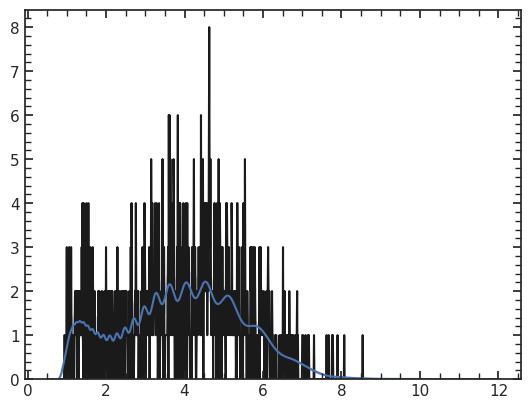

In [11]:
res.get_samples(10000)

fig, ax = plt.subplots()
ax.plot(promptlist.to_hist(asimov.Eedges).E, promptlist.to_hist(asimov.Eedges).counts, 'k-', zorder = -1)
orsa.plot.model_ci(res, 1000, [3], ax = ax)

In [12]:
min_func_unb = orsa.probability.CostFunction(ll=orsa.probability.ll_unbinned, ll_args=dict(data=promptlist))
min_func_unb.lp_args = min_func_bin.lp_args

m_res_unb = orsa.fit.minuit(model, min_func_unb, res.model)

Cost function parsed as LogLikelihood-like


(<Figure size 1000x600 with 14 Axes>,
 array([<Axes: title={'center': '$\\epsilon$'}>,
        <Axes: title={'center': '$a$'}>, <Axes: title={'center': '$b$'}>,
        <Axes: title={'center': '$c$'}>,
        <Axes: title={'center': '$a^{nl}_0$'}>,
        <Axes: title={'center': '$a^{nl}_1$'}>,
        <Axes: title={'center': '$a^{nl}_2$'}>,
        <Axes: title={'center': '$a^{nl}_3$'}>,
        <Axes: title={'center': '$\\rho$'}>,
        <Axes: title={'center': '$\\Delta m^2_{21}$'}>,
        <Axes: title={'center': '$\\Delta m^2_{31}$'}>,
        <Axes: title={'center': '$\\sin^2 \\theta_{12}$'}>,
        <Axes: title={'center': '$\\sin^2 \\theta_{13}$'}>,
        <Axes: title={'center': '$N_\\mathrm{rea}$'}>, <Axes: >],
       dtype=object))

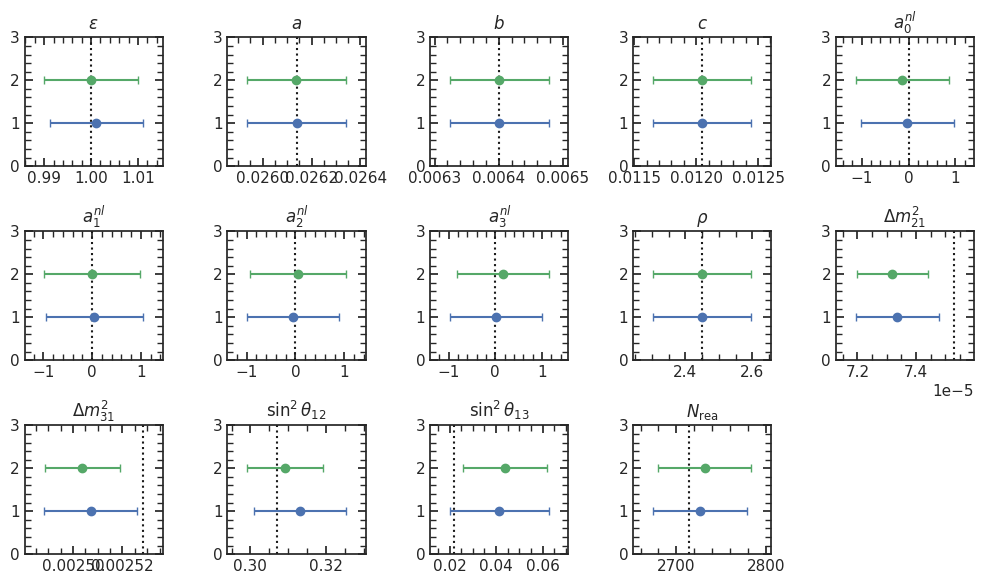

In [13]:
orsa.plot.bars([res, m_res_unb], true_values=True)